# 63_inclass_cluster_example

Preprocess data, a bit of feature engineering, PCA, clustering and then plotting

## Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import datetime

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Set max rows and columns displayed in jupyter
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

#the following gives access to utils folder
#where utils package stores shared code
import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.getcwd(),
                  os.pardir)
)

#only add it once
if (PROJECT_ROOT not in sys.path):
    sys.path.append(PROJECT_ROOT)

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

import utils as ut

## Constants and Functions
Migrate these to a separate package when done so they can be used with scripts

In [2]:
F_NEW="Mall_CustomersNew.csv"
RSEED=7

#lets compare each feature to all other features
def show_pairplot(df, hue):
    '''
    Shows a pairplot comparing all the features in a dataframe
    '''
    #this works on a small dataset, will be prohibitivly slow on a larger one
    To_Plot = [ col for col in df.columns]
    print("Relative Plot Of Some Selected Features: A Data Subset")
    plt.figure()
    sns.pairplot(data=df[To_Plot], hue=hue, palette=ut.colors1)
    plt.show();

## Load Data

In [3]:
#load
df= pd.read_csv(F_NEW)
df

,CustomerID,Gender,Annual Income (k$),Birthday,spending_alcohol,spending_food,spending_sale,Active
0,1,Male,15.0,2004-04-22,11.623344,8.185354,19.191302,True
1,2,Male,15.0,2002-09-05,26.986170,27.769286,26.244544,True
2,3,Female,16.0,2003-10-28,1.087533,1.697070,3.215396,True
3,4,Female,16.0,2000-09-02,26.988725,17.576664,32.434611,True
4,5,Female,17.0,1992-11-10,12.693410,12.820811,14.485779,True
...,...,...,...,...,...,...,...,...
200,200,Male,137.0,1993-07-15,42.905180,29.614241,10.480579,True
201,200,Male,137.0,1993-07-15,42.905180,29.614241,10.480579,True
202,200,Male,137.0,1993-07-15,42.905180,29.614241,10.480579,True
203,200,Male,137.0,1993-07-15,42.905180,29.614241,10.480579,True


### sns.pairplot to see if anything looks funny
In this case Active has no variance and CustomerID is weirdly correlated with Annual Income.  It appears that they collected all customer data, sorted by income, and then assigned a customer ID to the sorted data

In [4]:
# show_pairplot(df,hue='Gender')

## Clean Data

In [5]:
from utils.transforms import *

### Drop duplicates 

In [6]:
df=ut.remove_duplicates(df)

Removing 5 duplicate rows


### Handle nulls
Just drop if there are not too many and you can't figure out how to estimate<br>
(You could estimate by taking the value before and after since the data was sorted by income before CustomerIDs were assigned)

In [7]:
#how many rows have nulls?
df.isna().sum(axis=1).sum()

#see em
# df[df.isnull().any(axis=1)]

1

In [8]:
#only 1 null row, drop it
df.dropna(axis=0, inplace=True)

### Birthday-convert to Age in years

In [9]:
#convert birthday to age in years
import datetime
def getyear(v):
    return datetime.datetime.now().year - pd.to_datetime(v).year
df['Birthday']=df.Birthday.map(getyear) 
df.rename(columns={"Birthday": "Age"}, inplace=True)

### Correlations?
Careful you want to drop the columns with the least info

In [10]:
#any correlations?
ut.get_correlated_columns(df)

[('Annual Income (k$)', 'CustomerID')]

<AxesSubplot:xlabel='CustomerID', ylabel='Annual Income (k$)'>

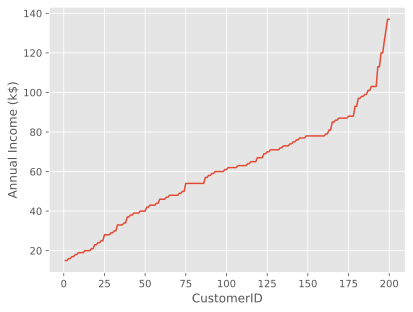

In [11]:
sns.lineplot(data=df, y='Annual Income (k$)',x='CustomerID')

#### Annual Income is highly (and weirdly) correlated with CustomerID, drop one.  But be sure to keep the one that has the most information!

Looks like they sorted the dataset by incone then assigned consecutive IDs

CustomerID is likely unique for every customer, and contains no info, drop it

In [12]:
print(f'There are {df.CustomerID.nunique()} unique customer IDs and {len(df)} rows in df')

There are 199 unique customer IDs and 199 rows in df


In [13]:
df.drop(columns=['CustomerID'], inplace=True)

### Drop no variance columns

In [14]:
df=ut.drop_no_variance_columns(df)

dropping columns ['Active'] since each only has 1 value


### Feature engineering- combine all spending columns into 1.  This assummes one value can accurately capture spending patterns. This also reduces number of features

In [15]:
#lets combine the last 3 into 1
def combine_columns(df, newcolname, cols ):
    '''
    df: dataframe
    newcolname: the name of the column to create that has the sum of all columns in cols
    cols: list of columns to add
    return: modded dataframe
    '''
    df[newcolname] = df[cols].sum(axis=1)
    df.drop(cols, axis=1, inplace=True)
    return df

# cols=[col for col in df.columns if "spending" in col]
# data=combine_columns(df,"spending_total",cols)

### Categoricals

In [16]:
#find categoricals, use df.dtypes, look for the object columns
df.dtypes

Gender                 object
Annual Income (k$)    float64
Age                     int64
spending_alcohol      float64
spending_food         float64
spending_sale         float64
dtype: object

#### Gender 

In [17]:
#looks like Gender and Birthday
print (df.Gender.unique())

['Male' 'Female']


In [18]:
#gender is nominal, but it is binary ie male or female
#try a binary variable instead of dummies
feats=['Gender']

#either of these
#convert Gender
d= {v:i for i,v in enumerate(df.Gender.unique().tolist())}
df.Gender=df.Gender.map(d)
# df=ut.cat_ordinal(df, features=feats, order={'Gender':{'Male':0, 'Female':1}})

In [19]:
df

,Gender,Annual Income (k$),Age,spending_alcohol,spending_food,spending_sale
0,0,15.0,19,11.623344,8.185354,19.191302
1,0,15.0,21,26.986170,27.769286,26.244544
2,1,16.0,20,1.087533,1.697070,3.215396
3,1,16.0,23,26.988725,17.576664,32.434611
4,1,17.0,31,12.693410,12.820811,14.485779
...,...,...,...,...,...,...
194,1,120.0,47,3.653982,8.067995,4.278022
195,1,120.0,35,31.499436,40.778435,6.722129
196,1,126.0,45,11.646951,1.248153,15.104895
198,0,137.0,32,2.996245,5.727636,9.276119


### Save a copy of dataframe to append clusters to

In [20]:
dforig=df.copy()

### Standardize

In [21]:
df=ut.scale(df)

### PCA

In [22]:
## PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=.95, whiten=True)
features_pca=pd.DataFrame(pca.fit_transform(df))
print(f'Orig #features={df.shape[1]}, number features containing 95% of variance={features_pca.shape[1]}')

features_pca
pca.explained_variance_ratio_

Orig #features=6, number features containing 95% of variance=5


,0,1,2,3,4
0,-0.201814,-1.634639,1.295932,1.028097,-0.856749
1,-1.451091,-1.716597,0.107060,0.462858,-0.177847
2,0.802141,-1.620932,1.150029,1.921773,-1.309198
3,-1.281741,-1.673355,0.903056,-0.186383,-0.423705
4,0.072976,-1.642353,0.481680,0.659603,-0.406517
...,...,...,...,...,...
194,1.263057,2.288722,-0.244044,0.391277,-0.139579
195,-1.062924,2.148609,-2.373481,0.492843,-0.055950
196,0.849394,2.534587,0.415487,-0.537592,-0.548534
197,0.808594,3.029239,0.481443,0.929973,-0.604323


array([0.31332146, 0.19094043, 0.16476137, 0.14358413, 0.14099478])

# HDBscan

This first part will run HDBscan over several cluster_sizes and min_sample_sizes, calculating several methrics for each run

The runs are then sorted by metric of choice (currently silhouette score, but you can choose any of the other metrics in hdbres)

In [23]:
#hdbscan is not part of scikitlearn or a standard anaconda distribution, here is how to install
# !conda install -c conda-forge hdbscan -y

import hdbscan
from sklearn.metrics import silhouette_samples, silhouette_score

class hdbres():
    '''
    Bookkeeping class to hold data
    '''
    def __init__(self,min_cluster_size,min_samples,n_clusters,n_noise,labels, sil_score ):
        self.min_cluster_size=min_cluster_size
        self.min_samples=min_samples
        self.n_clusters=n_clusters
        self.n_noise=n_noise
        self.labels=labels  #all the cluster labels for my data
        self.sil_score=sil_score
    def __repr__(self):
        return str(f'self.min_cluster_size:{self.min_cluster_size},min_samples:{self.min_samples}, numb clusters:{self.n_clusters},noise points: {self.n_noise}, silhouette_score: {self.sil_score}\n')


def run_hdbscan(df, min_cluster_size,min_samples, verbose=True, ignore_outliers_for_sil_score=True):
    '''
    a hdbscan run for a set of parameters
    returns: hdbres object with all initializing params and results
    '''
    db = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    db=db.fit(df)

    #cluster labels for dataset
    cluster_labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)
    if(verbose):
        print(f'numb clusters:{n_clusters},noise points: {n_noise}')
    
    #ignore outliers when calculating silhouette score
    if ignore_outliers_for_sil_score:
        sil_score=silhouette_score(df[cluster_labels!=-1], cluster_labels[cluster_labels!=-1])
    else:
        sil_score=silhouette_score(df, cluster_labels)  
    return hdbres(min_cluster_size,min_samples,n_clusters,n_noise,cluster_labels,sil_score)

In [24]:
#check all combonations of following parameters
cluster_sizes=[6,7,8,9,10,11,12,13,14,15]
min_samps=[2,3,4]

res=[]
for min_samp in min_samps:
    for cluster_size in cluster_sizes:       
          res.append(run_hdbscan(features_pca, cluster_size,min_samp,False))  
print(sorted(res, key=lambda x: x.sil_score))

[self.min_cluster_size:13,min_samples:2, numb clusters:2,noise points: 102, silhouette_score: 0.1009175911268825
, self.min_cluster_size:14,min_samples:2, numb clusters:2,noise points: 102, silhouette_score: 0.1009175911268825
, self.min_cluster_size:15,min_samples:2, numb clusters:2,noise points: 102, silhouette_score: 0.1009175911268825
, self.min_cluster_size:7,min_samples:3, numb clusters:3,noise points: 124, silhouette_score: 0.14861058753012008
, self.min_cluster_size:8,min_samples:3, numb clusters:2,noise points: 116, silhouette_score: 0.16402030221896857
, self.min_cluster_size:9,min_samples:3, numb clusters:2,noise points: 116, silhouette_score: 0.16402030221896857
, self.min_cluster_size:10,min_samples:3, numb clusters:2,noise points: 116, silhouette_score: 0.16402030221896857
, self.min_cluster_size:11,min_samples:3, numb clusters:2,noise points: 116, silhouette_score: 0.16402030221896857
, self.min_cluster_size:12,min_samples:3, numb clusters:2,noise points: 116, silhouette

### Add the cluster predictions to original DataFrame (df)

In [25]:
#get the labels for a particulr run of interest
# for instance try the one with self.min_cluster_size:10,min_samples:2
cluster_labels=[x for x in res if x.min_cluster_size==7 and x.min_samples==2][0].labels

dforig['Cluster']=cluster_labels.tolist()
# dforig

### Silhouette plots?
The yellowbrick package has some pretty cool visualizers, the problem is that they work with kmeans.<br>
No Worries! All the visualizer needs is the original data and a way to get the predicted clusters.  See below for a hacked extension of HDBSCAN that works with yellowbrick visualizers. 

<mark>USE THIS ONLY TO GET SILHOUETTE SCORES PLOT!<mark>

Note that outliers are ignored when calculating the Silhouette score.

In [26]:
from joblib import Memory  #required 
class newHDBSCAN(hdbscan.HDBSCAN):
    
    #sklearn prohibits *args, and **kwargs in __init__, you must write out these params
    #for init see https://stackoverflow.com/questions/40025406/inherit-from-scikit-learns-lassocv-model
    def __init__(self, min_cluster_size=5, min_samples=None, cluster_selection_epsilon=0.0,
                 metric='euclidean', alpha=1.0, p=None,
                 algorithm='best', 
                 leaf_size=40,
                 memory=Memory(location=None),   #memory=Memory(cachedir=None, verbose=0),
                 approx_min_span_tree=True,
                 gen_min_span_tree=False,
                 core_dist_n_jobs=4,
                 cluster_selection_method='eom',
                 allow_single_cluster=False,
                 prediction_data=False,     #changed this from default
                 match_reference_implementation=False, **kwargs):
        super().__init__(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=cluster_selection_epsilon,
                 metric=metric, alpha=alpha, p=p,
                 algorithm=algorithm, leaf_size=leaf_size,
                 memory=memory,
                 approx_min_span_tree=approx_min_span_tree,
                 gen_min_span_tree=gen_min_span_tree,
                 core_dist_n_jobs=core_dist_n_jobs,
                 cluster_selection_method=cluster_selection_method,
                 allow_single_cluster=allow_single_cluster,
                 prediction_data=prediction_data,
                 match_reference_implementation=match_reference_implementation,**kwargs)
        self.n_clusters=0
        self.n_samples_=0
        self.labels_=[]
 
    def fit(self,*args,**kwargs):
        super().fit( *args,**kwargs)
        
        #lets get the data
        self.indices_=self.labels_!=-1
        self.labels_=self.labels_[self.labels_!=-1]
        self.n_samples_=len(self.labels_)
        
        #kmeans has a n_clusters param that yellowbrick expects, so provide it
        # Number of clusters in labels, ignoring noise if present.
        self.n_clusters=len(set(self.labels_))
        return self
    
    def predict(self,X):
        '''
        This is SUPER hacky, I'm assumming that the X passed in here is the same X that was fitted, OK for yellowbrick
        '''
        # test_labels, _ = hdbscan.approximate_predict(self, X)
        # return test_labels
        return self.labels_

Use the above class to plot the silhouette plots using YellowBrick for the estimator of your choice

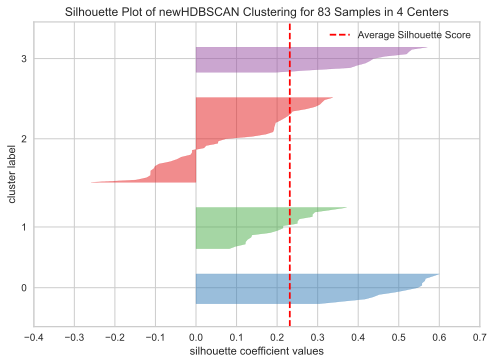

In [27]:
from yellowbrick.style.palettes import PALETTES, SEQUENCES, color_palette
db = newHDBSCAN(min_cluster_size=10, min_samples=2).fit(features_pca)

from yellowbrick.cluster import SilhouetteVisualizer
visualizer = SilhouetteVisualizer(db, colors=color_palette('bold'),isfitted=True)

#only pass in the non-outlier points calculated in line 1 of this cell
visualizer.fit(features_pca[db.indices_])        # Fit the data to the visualizer
visualizer.show();

### Beware of Silhoutte plots when used with HDBScan
HDBScan will generate long moon or snake shaped clusters since it follows the densest path. If you have a moon cluster and a spherical cluster near the end of the moon cluster, then the end points in the moon cluster will probably be marked as misclassified by silhouette analysis because the average distance to every point in the moon is probably greater than the average distance to every point in the spherical cluster. 

See below, silhoutte will incorrectly say the blue moon points around (1, -.1) are incorrectly classified as moon when they should be yellow blob.

/tmp/ipykernel_613644/2638893145.py:15: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=X, x=X[:,0], y=X[:,1], hue=labs, palette=color_palette('bold'));


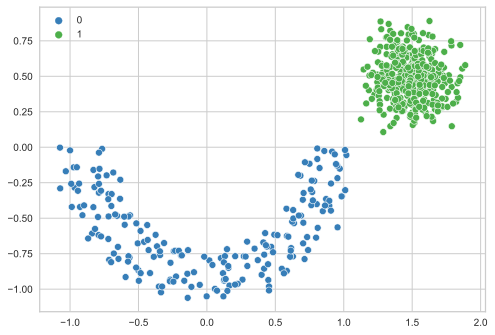

In [28]:
#generate some data
import sklearn.datasets as data
# moons, _ = data.make_moons(n_samples=200, noise=0.05)
circs, _ = data.make_circles(n_samples=400,noise=0.05)
circs=[[x,y] for x,y in circs if y <=0.0]
blobs, _ = data.make_blobs(n_samples=400, centers=[(1.5, 0.5)], cluster_std=0.15)
X = np.vstack([circs, blobs])
plot_kwds = {'alpha' : 0.5, 's' : 20, 'linewidths':0}
# plt.scatter(X.T[0], X.T[1], color='b', **plot_kwds);

db = newHDBSCAN(min_cluster_size=10, min_samples=2).fit(X)
labs=db.labels_

# sns.scatterplot(data=X, x=X[:,0], y=X[:,1], hue=labs, palette=ut.colors1);
sns.scatterplot(data=X, x=X[:,0], y=X[:,1], hue=labs, palette=color_palette('bold'));

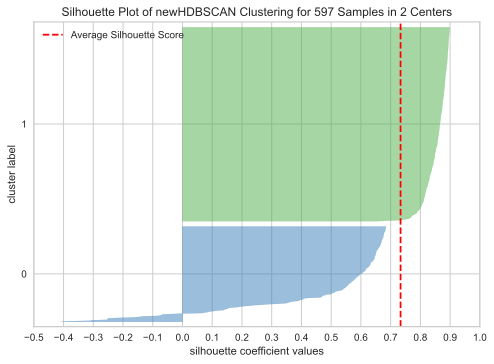

In [29]:
visualizer = SilhouetteVisualizer(db, colors=color_palette('bold'),isfitted=True)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show();

### What do the plots mean? If anything.
You can only look at 3 features at a time if you are showing clusters as colors.<br>
So look at a plot of all females, and then all males.  ARe any clusters exclusively female or male? <br>
ARe there any other clusters that clearly indicate similarities?<br>
Are there any that appear to be pointlessly mixed with other clusters?<br>
If so should you try reducing the number of clusters calculated?

In [ ]:
#only show non outliers
show_pairplot(dforig[dforig['Cluster']!=-1],hue='Cluster');

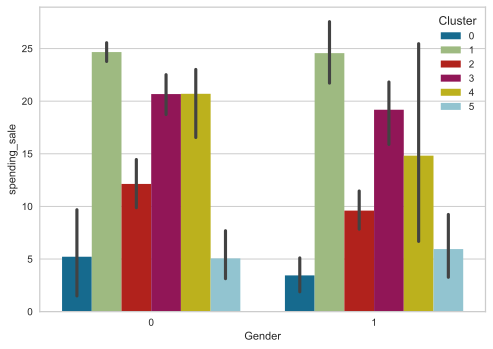

In [30]:
#looks like there is a relationship between Gender and age for cluster membership, lets plot
# sns.barplot(data=dforig[dforig['Cluster']!=-1], y='Age',x='Gender',hue='Cluster');
sns.barplot(data=dforig[dforig['Cluster']!=-1], y='spending_sale',x='Gender',hue='Cluster');
# sns.barplot(data=dforig[dforig['Cluster']!=-1], y='spending_alcohol',x='Annual Income (k$)',hue='Cluster');

In [31]:
dforig.nunique()

Gender                  2
Annual Income (k$)     64
Age                    51
spending_alcohol      199
spending_food         199
spending_sale         199
Cluster                 7
dtype: int64

In [ ]:
#here is the problem, we should reduce the cardinality of every column except gender and Cluster
#we will do it by binning